Use the model from https://resourcewatch.org/data/explore/Wat063-Plastic-Input-in-Rivers?section=Discover&selectedCollection=&zoom=11.220883753497942&lat=8.666165796812479&lng=-60.882446428277014&pitch=0&bearing=0&basemap=dark&labels=light&layers=%255B%257B%2522dataset%2522%253A%252238e1bdc7-a843-40b8-ac86-2e47ccd896e4%2522%252C%2522opacity%2522%253A1%252C%2522layer%2522%253A%25228ad07c40-dbb6-4703-8146-a36b9f441dd2%2522%257D%255D&aoi=&page=1&sort=most-viewed&sortDirection=-1 to predict plastic inputs mass/day from rivers.

# Load data

In [1]:
import geopandas as gpd

In [2]:
# Model regression parameters
k = 1.85e-3
a = 1.52

In [3]:
df = gpd.read_file("river_inputs/PlasticRiverInputs.shp")
df.head()

,i_mid,i_low,i_high,i_mid_jan,i_low_jan,i_high_jan,i_mid_feb,i_low_feb,i_high_feb,i_mid_mar,...,runoff_jun,runoff_jul,runoff_aug,runoff_sep,runoff_oct,runoff_nov,runoff_dec,mpw,area,geometry
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21753.3,22500000.0,POINT (9.81250 37.32917)
1,0.117503,0.046447,0.431570,0.008847,0.003387,0.033584,0.025464,0.010425,0.089840,0.022978,...,0.275476,0.172272,0.075899,0.067729,0.176044,0.588417,0.466081,506114.0,95100000.0,POINT (9.38750 37.25417)
2,0.004653,0.001518,0.021067,0.000364,0.000116,0.001692,0.000750,0.000250,0.003305,0.000905,...,0.321421,0.236187,0.135462,0.101813,0.223936,0.821796,0.500808,56294.6,33500000.0,POINT (9.80417 37.23750)
3,0.163098,0.065719,0.586740,0.019418,0.007780,0.070142,0.041209,0.017347,0.141035,0.030320,...,0.422857,0.275328,0.182635,0.184765,0.335541,1.101117,0.927117,349409.0,99200000.0,POINT (9.22917 37.22083)
4,0.038200,0.014144,0.150693,0.003528,0.001281,0.014193,0.008848,0.003407,0.033372,0.007342,...,0.315671,0.200378,0.105010,0.099647,0.219543,0.728243,0.591818,199000.0,39700000.0,POINT (9.25417 37.22083)


<AxesSubplot:>

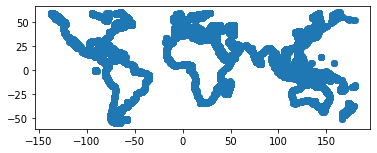

In [4]:
df.plot()

In [5]:
df.keys()

Index(['i_mid', 'i_low', 'i_high', 'i_mid_jan', 'i_low_jan', 'i_high_jan',
       'i_mid_feb', 'i_low_feb', 'i_high_feb', 'i_mid_mar', 'i_low_mar',
       'i_high_mar', 'i_mid_apr', 'i_low_apr', 'i_high_apr', 'i_mid_may',
       'i_low_may', 'i_high_may', 'i_mid_jun', 'i_low_jun', 'i_high_jun',
       'i_mid_jul', 'i_low_jul', 'i_high_jul', 'i_mid_aug', 'i_low_aug',
       'i_high_aug', 'i_mid_sep', 'i_low_sep', 'i_high_sep', 'i_mid_oct',
       'i_low_oct', 'i_high_oct', 'i_mid_nov', 'i_low_nov', 'i_high_nov',
       'i_mid_dec', 'i_low_dec', 'i_high_dec', 'runoff_jan', 'runoff_feb',
       'runoff_mar', 'runoff_apr', 'runoff_may', 'runoff_jun', 'runoff_jul',
       'runoff_aug', 'runoff_sep', 'runoff_oct', 'runoff_nov', 'runoff_dec',
       'mpw', 'area', 'geometry'],
      dtype='object')

# Compute model

Here we compute the plastic mass spilling from points using the model.

In [6]:
def compute_plastic_mass(mpw, R):
    return (k * mpw * R) ** a

In [7]:
MOUNTHS = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

In [8]:
def compute_model(df):
    model = gpd.GeoDataFrame()
    for mounth in MOUNTHS:
        model[f"m_out_{mounth}"] = compute_plastic_mass(df["mpw"], df[f"runoff_{mounth}"])
    model["m_out"] = compute_plastic_mass(df["mpw"], df[f"runoff_{mounth}"])
    return model

In [9]:
model = compute_model(df)
model[["area", "mpw", "geometry"]] = df[["area", "mpw", "geometry"]]
model["m_out_max"] = model.loc[:,[f"m_out_{mounth}" for mounth in MOUNTHS]].max(axis=1)

In [10]:
model = model[model["m_out_max"].astype('float32') != 0.0]

In [11]:
model = model.sort_values(["m_out_max"], ascending=False)

# Results
MPW stands for Mismanaged Plastic Waste 

m_out stands for plastic mass release



The units are: 

MPW -> kg/day 

m_out -> kg/day

area -> m²

In [39]:
print(len(model))
model.head()

35821


,m_out_jan,m_out_feb,m_out_mar,m_out_apr,m_out_may,m_out_jun,m_out_jul,m_out_aug,m_out_sep,m_out_oct,m_out_nov,m_out_dec,m_out,geometry,area,mpw,m_out_max
7310,2.861151e+09,3.989828e+09,1.198069e+10,2.648229e+10,4.942422e+10,7.283720e+10,8.798777e+10,5.552361e+10,4.466158e+10,1.764323e+10,1.227249e+10,5.440373e+09,5.440373e+09,POINT (120.23750 31.93750),1.910530e+12,5.685870e+09,8.798777e+10
7804,5.884826e+07,6.244939e+07,1.583727e+08,7.601362e+08,3.236602e+09,1.028385e+10,3.240771e+10,5.162278e+10,2.932790e+10,6.554515e+09,5.594960e+08,1.362908e+08,1.362908e+08,POINT (90.62917 23.22083),1.574326e+12,1.486410e+09,5.162278e+10
8001,2.141598e+08,1.665886e+08,4.777611e+08,2.498976e+09,1.125639e+10,3.415285e+10,1.841135e+10,1.156611e+10,5.344680e+09,1.385208e+09,1.109169e+09,5.130585e+08,5.130585e+08,POINT (113.25417 22.39583),3.887689e+11,1.100360e+09,3.415285e+10
10949,2.052326e+09,1.271270e+09,1.472676e+09,8.299380e+09,4.091441e+09,5.625883e+09,6.162356e+09,4.109529e+09,4.001408e+09,1.736787e+10,2.050048e+10,8.154007e+09,8.154007e+09,POINT (79.87083 6.97083),2.300400e+09,2.553780e+08,2.050048e+10
2051,2.233180e+07,1.546193e+07,2.471526e+08,1.040669e+09,1.709158e+09,3.417093e+09,4.517124e+09,9.317464e+09,1.581911e+10,8.873652e+09,2.302188e+09,1.800524e+08,1.800524e+08,POINT (8.25417 4.82083),5.283030e+10,3.411000e+08,1.581911e+10
